# Sentinel2 Satellite image downloader using.

Library: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)

Sentinel Hub is a cloud-based platform that provides easy access to satellite imagery and geospatial data from various Earth observation missions, including Sentinel-1, Sentinel-2, and others.

In this notebook, we explore how to access and download satellite imagery from Sentinel Hub using its powerful [API](https://dataspace.copernicus.eu/analyse/apis). By leveraging Sentinel Hub’s capabilities, we can retrieve data from these missions and process it to meet specific analysis requirements, making it a useful tool for environmental monitoring, geospatial analysis, and research applications.




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import dependencies


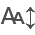

In [2]:
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    MosaickingOrder,
)

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets

import rasterio
from rasterio.transform import from_bounds
import leafmap

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

## Manage Working Directories

In [3]:
# The directories (if doesn't exist) will be created in the Data folder
download_folder = r".\data\sentinelhub\download"

if not os.path.exists(download_folder):
    os.makedirs(download_folder)

### API and Authentication


In [4]:
# # Only run this cell if you have not created a configuration.
# config = SHConfig()
# config.sh_client_id = '**-********-****-****-****-************'
# config.sh_client_secret = '********************************'

# config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
# config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# config.save("cdse")

In [5]:
config = SHConfig("cdse")

## Define parameters for download

In [6]:
# Define the bounding box extents in CRS: WGS84 in this format [lon_min, lat_min, lon_max, lat_max]

bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160] # Bounding box for Konstanz, Germany
resolution = 10 # Primary bands of Sentilen2 have spatial resolution of 10m
# Read more at https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

In [7]:
initial_date = widgets.DatePicker(description="Select initial date: ",
                                  style=dict(description_width='initial'),
                                  disabled=False,
                                  value=datetime.date(2024,1,1))
initial_date

DatePicker(value=datetime.date(2024, 1, 1), description='Select initial date: ', step=1, style=DescriptionStyl…

In [8]:
final_date = widgets.DatePicker(description="Select final date: ",
                                style=dict(description_width='initial'),
                                disabled=False,
                                value=datetime.date.today())
final_date

DatePicker(value=datetime.date(2024, 11, 22), description='Select final date: ', step=1, style=DescriptionStyl…

In [9]:
time_interval = (str(initial_date.value), str(final_date.value))

## Retrieve available dataset from SHcatalog

In [10]:
catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    filter=f"eo:cloud_cover <= {20}",
    fields={"include": ["id",
                        "properties.datetime",
                        "properties.eo:cloud_cover",
                        "properties.platform",
                        ],
            "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

data = []
for entry in results:
    id = entry['id']
    dt = entry['properties']['datetime']
    date, time = dt.split('T')
    time = time.replace('Z', '')
    cloud_cover = entry['properties']['eo:cloud_cover']
    data.append({#'Id':id,
                 'Date':date, 
                 'Time':time,
                 'Cloud Cover (%)':cloud_cover})

df = pd.DataFrame(data)
df

Total number of results: 35


Date          Time  Cloud Cover (%)
0   2024-11-16  10:27:44.793            16.32
1   2024-11-01  10:27:44.359            17.88
2   2024-09-20  10:37:46.875             1.14
3   2024-09-20   10:37:42.13             2.66
4   2024-09-07   10:27:48.89             2.52
5   2024-09-07  10:27:45.742             0.51
6   2024-09-07  10:27:40.714             0.00
7   2024-09-07  10:27:39.135             0.04
8   2024-08-28  10:27:47.301             1.45
9   2024-08-28  10:27:43.528            15.08
10  2024-08-23  10:27:45.974             0.08
11  2024-08-23  10:27:44.048             0.37
12  2024-08-16  10:37:48.979            17.49
13  2024-08-11  10:37:47.273            15.48
14  2024-08-11  10:37:42.547             0.87
15  2024-08-06  10:37:48.665             8.07
16  2024-08-06  10:37:43.937             1.16
17  2024-07-29  10:27:51.691             9.07
18  2024-07-27  10:37:48.099            16.40
19  2024-07-27  10:37:43.381            14.88
20  2024-07-19  10:27:45.978            15.35
21  2024-07-14  10:27:47.904            19.77
22  2024-06-29  10:27:48.303             9.78
23  2024-06-19  10:27:54.375             1.50
24  2024-06-19  10:27:50.587             3.44
25  2024-05-10  10:27:51.998             5.33
26  2024-03-19  10:37:40.654            11.44
27  2024-02-25  10:27:48.613             5.66
28  2024-02-25  10:27:44.834            12.70
29  2024-02-13  10:37:43.214            16.27
30  2024-02-13  10:37:38.503            12.60
31  2024-02-05  10:27:47.669            14.53
32  2024-02-05  10:27:43.897             4.53
33  2024-02-03  10:37:41.626             0.16
34  2024-02-03  10:37:36.934             0.08

## Define Evaluation scripts for access and download

In [11]:
evalscript_sentinel2_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

In [12]:
# Request data with least CC

request_all_bands = SentinelHubRequest(
    data_folder = download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            # Mosiac of least cloudy acquisitions
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

all_bands_response = request_all_bands.get_data(save_data=False)

In [13]:
# Request data using the table "df"
request_all_bands = SentinelHubRequest(
    data_folder=download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval='2024-08-23',
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Get the data
all_bands_response = request_all_bands.get_data(save_data=False)

### Plot true color raster

In [14]:
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (15, 15),
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(figsize=figsize)
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

9.0 3631.0


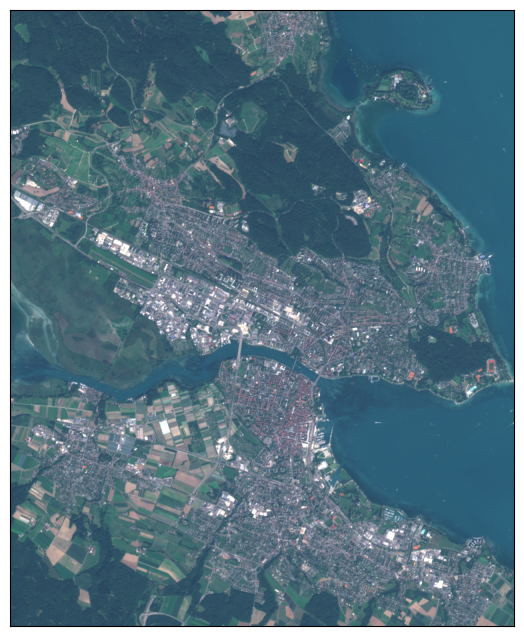

In [15]:
image = all_bands_response[0]
min_val = np.percentile(image, 2)  # 2nd percentile
max_val = np.percentile(image, 98)  # 98th percentile
factor = 1.0 / max_val
factor_multiplier = 1.7
print(min_val, max_val)

plot_image(
    image[:, :, [3, 2, 1]],
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

### Plot using leafmap

In [16]:
height, width, bands = image.shape
transform = from_bounds(*bbox_wgs84, width=width, height=height)

rgb_image = image[:, :, [3, 2, 1]]
clipped_image = np.clip(rgb_image * factor * factor_multiplier, 0, 1)
uint8_image = (clipped_image * 255).astype(np.uint8)

temp_tif = os.path.join(download_folder,"temp.tif")
with rasterio.open(
    temp_tif,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=3,  # Only 3 bands for RGB
    dtype=image.dtype,
    crs="EPSG:4326",  # WGS84 coordinate reference system
    transform=transform,
) as dst:
    for i in range(3):  # Loop through the RGB bands
        dst.write(uint8_image[:, :, i], i + 1)

In [20]:
m = leafmap.Map(center=[(bbox_wgs84[1] + bbox_wgs84[3]) / 2, (bbox_wgs84[0] + bbox_wgs84[2]) / 2], zoom=14)
m.add_raster(
    temp_tif,
    bands=[1,2,3],
)
m

Map(center=[47.6745, 9.1675], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

### Plot false color

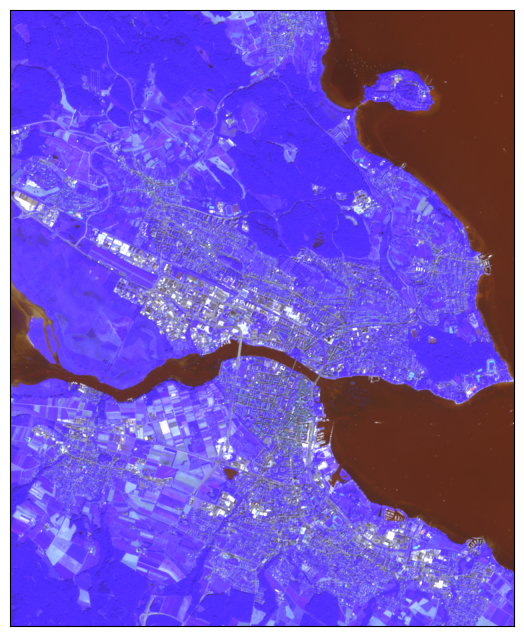

In [18]:
plot_image(
    image[:, :, [2, 3, 7]],
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

### Plot NDVI

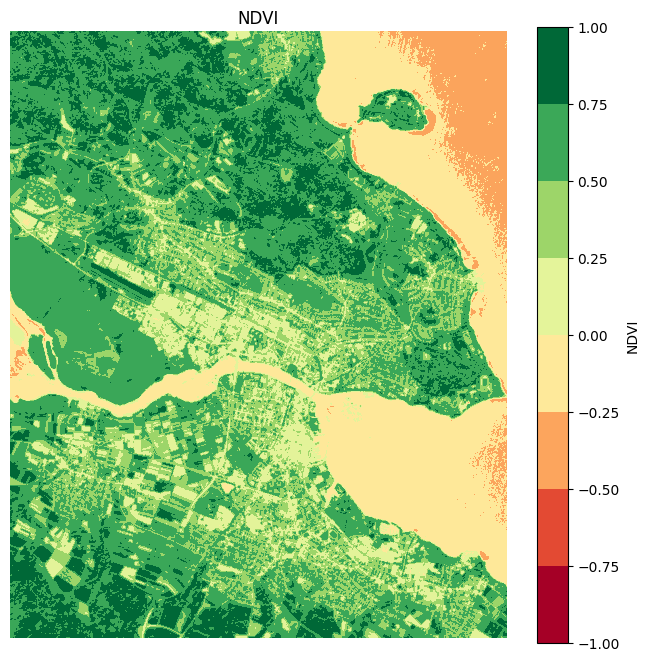

In [19]:
# Extract the NIR (Band 8) and Red (Band 4) bands
nir = all_bands_response[0][:, :, 7]
red = all_bands_response[0][:, :, 3]

# Compute NDVI (Add a small number to denominator to avoid division by zero)
ndvi = (nir - red) / (nir + red + 1e-10) 

# Plot NDVI
plt.figure(figsize=(8, 8))
cmap = plt.get_cmap('RdYlGn',8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.axis('off')
plt.show()
